In [56]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

In [57]:
# -------------------------
# 1. Utilities / indicators
# -------------------------

def SMA(series, period):
    return series.rolling(period).mean()

def EMA(series, period):
    return series.ewm(span=period,adjust=False).mean()

def RSI(series, period=14):
    delta=series.diff()
    up=delta.clip(lower=0)
    down=-1*delta.clip(upper=0)
    ma_up=up.ewm(alpha=1/period,adjust=False).mean()
    ma_down=down.ewm(alpha=1/period,adjust=False).mean()
    rs=ma_up/(ma_down+1e-12)
    rsi=100-(100/(1+rs))
    return rsi

def MACD(series, fast=12, slow=26, signal=9):
    fast_ema=EMA(series,fast)
    slow_ema=EMA(series,slow)
    macd_line=fast_ema-slow_ema
    signal_line=EMA(macd_line, signal)
    hist=macd_line-signal_line
    return macd_line, signal_line, hist

def bollinger_bands(series, window=20, n_std=2):
    sma=SMA(series, window)
    std=series.rolling(window).std()
    upper=sma+n_std*std
    lower=sma-n_std*std
    return upper, lower

In [58]:
# -------------------------
# 2. Feature engineering
# -------------------------

def add_indicators(df):
    df=df.copy()
    price=df['Close']
    df['SMA_10']=SMA(price, 10)
    df['SMA_50']=SMA(price, 50)
    df['EMA_20']=EMA(price, 20)
    df['RSI_14']=RSI(price, 14)
    macd_line, macd_sig, macd_hist=MACD(price)
    df['MACD']=macd_line
    df['MACD_signal']=macd_sig
    df['MACD_hist']=macd_hist
    df['BB_upper'], df['BB_lower']=bollinger_bands(price, 20, 2)
    # Returns & volatility
    df['ret1']=price.pct_change(1)
    df['ret5']=price.pct_change(5)
    df['vol_20']=df['ret1'].rolling(20).std()
    # Lag features
    df['close_lag1']=price.shift(1)
    df['sma50_lag1']=df['SMA_50'].shift(1)
    return df

In [59]:
# -------------------------
# 3. Label generation
# -------------------------

def make_labels(df, forward=1, threshold=0.0):
    """
    Binary label: 1 if forward-day return > threshold, else 0.
    threshold allows you to require minimal move (e.g., 0.001 for 0.1%).
    """
    df = df.copy()
    df['future_ret']=df['Close'].pct_change(periods=forward).shift(-forward)
    df['label']=(df['future_ret']>threshold).astype(int)
    return df

In [60]:
import numpy as np
import pandas as pd

def rule_signals(df):
    """
    Robust rule-based signal generator that avoids pandas alignment pitfalls.
    Produces 'rule_long' column (0/1) and preserves df.index as-is.
    """
    df=df.copy()
    if 'Date' in df.columns and not isinstance(df.index, pd.DatetimeIndex):
        try:
            df.set_index(pd.to_datetime(df['Date']), inplace=True)
        except Exception:
            pass
    required=['Close', 'SMA_50', 'RSI_14']
    missing=[c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing columns required by rule_signals_safe: {missing}. Available cols: {df.columns.tolist()}")
    price=df['Close'].to_numpy(dtype=float)
    sma50=df['SMA_50'].to_numpy(dtype=float)
    rsi=df['RSI_14'].to_numpy(dtype=float)

    prev_close=np.empty_like(price); prev_close[:]=np.nan
    prev_close[1:]=price[:-1]
    prev_sma=np.empty_like(sma50); prev_sma[:]=np.nan
    prev_sma[1:]=sma50[:-1]

    cross_up=(prev_close<prev_sma)&(price>sma50)
    cross_down=(prev_close>prev_sma)&(price<sma50)

    rule_long=np.zeros(len(price), dtype=int)
    enter_idx=np.where(cross_up&(rsi<60))[0]
    rule_long[enter_idx]=1
    exit_idx=np.where(cross_down | (rsi > 70))[0]

    rule_s=pd.Series(rule_long, index=df.index)
    # forward-fill to hold position until an exit; then fill remaining NaNs with 0
    rule_s=rule_s.replace(0, np.nan).ffill().fillna(0).astype(int)

    df['rule_long'] = rule_s
    return df

In [61]:
# -------------------------
# 5. ML Model training
# -------------------------

def train_ml_model(df, feature_cols, model=None):
    df=df.dropna(subset=feature_cols + ['label']).copy()
    X=df[feature_cols]
    y=df['label']
    #train/test split by time (last 20% test)
    split_idx=int(len(df)*0.8)
    X_train, X_test=X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test=y.iloc[:split_idx], y.iloc[split_idx:]

    scaler=StandardScaler()
    X_train_s=scaler.fit_transform(X_train)
    X_test_s=scaler.transform(X_test)

    if model is None:
        model=RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    model.fit(X_train_s, y_train)
    prob_train=model.predict_proba(X_train_s)[:, 1]
    prob_test=model.predict_proba(X_test_s)[:, 1]
    yhat_test=model.predict(X_test_s)

    metrics = {
        'acc_train': accuracy_score(y_train, model.predict(X_train_s)),
        'acc_test': accuracy_score(y_test, yhat_test),
        'auc_test': roc_auc_score(y_test, prob_test)
    }
    # attach predictions to df
    df.loc[X_test.index, 'ml_proba']=prob_test
    df.loc[X_train.index, 'ml_proba']=prob_train
    df['ml_proba'] = df['ml_proba'].fillna(method='ffill').fillna(0.5)
    return model, scaler, metrics, df

In [62]:
# -------------------------
# 6. Combine signals
# -------------------------

def combined_signal(df, ml_threshold=0.6, rule_weight=0.5, ml_weight=0.5):
    """
    Combine: final_score = rule_long*rule_weight + ml_proba*ml_weight
    If final_score > threshold_signal -> long (1), else flat (0)
    This is simplistic; you can also require both conditions (AND) or use probability scaling.
    """
    df=df.copy()
    df['final_score'] = df['rule_long']*rule_weight + df['ml_proba']*ml_weight
    # choose threshold for going long
    df['signal']=(df['final_score']>ml_threshold).astype(int)
    return df

In [64]:
# -------------------------
# 7. Backtester (daily loop)
# -------------------------

class BacktestEngine:
    def __init__(self, df, initial_cash=100000, commission=0.0005, slippage=0.0005):
        """
        commission: proportion of trade value (e.g., 0.0005 = 0.05%)
        slippage: proportion of price moved vs ideal
        """
        self.df=df.copy()
        self.initial_cash=initial_cash
        self.cash=initial_cash
        self.position=0
        self.commission=commission
        self.slippage=slippage
        self.equity_curve=[]

    def run(self):
        for date, row in self.df.iterrows():
            close=row['Close']
            signal=int(row.get('signal', 0))

            # if signal = 1 and no position -> buy full allocation (here: 90% of equity)
            equity=self.cash+self.position*close
            allocation=0.9  # fraction of equity to allocate when entering a trade
            target_value=equity*allocation

            if signal==1 and self.position==0:
                # buy shares
                target_shares=int((target_value)/close)
                if target_shares>0:
                    # execution price with slippage (buy higher)
                    exec_price=close*(1+self.slippage)
                    trade_value=exec_price*target_shares
                    cost=trade_value*self.commission
                    total_cost=trade_value+cost
                    if total_cost<=self.cash:
                        self.cash-= total_cost
                        self.position+= target_shares
            elif signal== 0 and self.position > 0:
                # sell everything
                exec_price=close*(1-self.slippage)  # sell lower
                trade_value=exec_price*self.position
                cost=trade_value*self.commission
                proceeds=trade_value-cost
                self.cash+=proceeds
                self.position=0

            # daily equity recording (mark-to-market)
            equity=self.cash+self.position*close
            self.equity_curve.append({
                'Date': date,
                'Equity': equity,
                'Cash': self.cash,
                'Position': self.position,
                'Close': close
            })

        return pd.DataFrame(self.equity_curve)

In [65]:
import numpy as np
import pandas as pd

def backtest_metrics(returns, risk_free=0.0, periods_per_year=252):
    """
    Compute common backtest performance metrics with proper annualization.
    returns: pandas Series or numpy array of periodic returns (daily if periods_per_year=252).
    risk_free: risk-free rate per period (0 by default).
    """
    returns=pd.Series(returns).dropna()

    # Cumulative return
    cumulative=(1 + returns).prod()-1
    # Annualized return
    ann_return=(1 + cumulative)**(periods_per_year/len(returns))-1
    # Annualized volatility
    ann_vol=returns.std()*np.sqrt(periods_per_year)
    # Excess returns
    excess_ret=returns-risk_free
    # Sharpe ratio (annualized)
    sharpe = (
        (excess_ret.mean()*periods_per_year)/(excess_ret.std(ddof=1)*np.sqrt(periods_per_year))
        if excess_ret.std(ddof=1)!=0 else np.nan
    )
    # Sortino ratio (annualized, uses downside deviation)
    downside = excess_ret[excess_ret < 0]
    downside_std = downside.std(ddof=1)
    sortino = (
        (excess_ret.mean()*periods_per_year)/(downside_std*np.sqrt(periods_per_year))
        if downside_std!= 0 else np.nan
    )
    # Max drawdown
    cum_curve=(1 + returns).cumprod()
    running_max=cum_curve.cummax()
    drawdown=(cum_curve - running_max) / running_max
    max_dd=drawdown.min()

    return {
        "Cumulative Return": cumulative,
        "Annualized Return": ann_return,
        "Annualized Volatility": ann_vol,
        "Sharpe Ratio": sharpe,
        "Sortino Ratio": sortino,
        "Max Drawdown": max_dd
    }

In [ ]:

def main():
    # 1) Download data
    ticker="AAPL"
    start="2015-01-01"
    end="2025-09-12"
    print(f"Downloading {ticker} from {start} to {end} ...")
    data=yf.download(ticker, start=start, end=end, progress=False)
    data.reset_index(inplace=True)
    data.columns=['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
    # data = data[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    print(data.head())
    # 2) Add indicators
    data=add_indicators(data)
    # 3) Make labels for ML (predict next-day up move > 0)
    data=make_labels(data, forward=1, threshold=0.0)
    # 4) Rule signals
    data=rule_signals(data)

    # 5) Train ML model
    feature_cols=['SMA_10', 'SMA_50', 'EMA_20', 'RSI_14', 'MACD', 'MACD_hist', 'BB_upper', 'BB_lower', 'ret1', 'ret5', 'vol_20']
    # drop NaN features automatically in train function
    model, scaler, metrics, data_with_proba=train_ml_model(data, feature_cols)
    print("ML metrics:", metrics)
    # 6) Combine signals
    combo=combined_signal(data_with_proba, ml_threshold=0.6, rule_weight=0.5, ml_weight=0.5)

    # 7) Backtest
    bt=BacktestEngine(combo, initial_cash=100000, commission=0.0005, slippage=0.0005)
    equity_df=bt.run()
    equity_df['Return']=equity_df['Equity'].pct_change().fillna(0)
    # 8) Performance
    metrics=backtest_metrics(equity_df['Return'])
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    # 9) Plot equity curve and sample price with trades
    plt.figure(figsize=(12, 6))
    plt.plot(pd.to_datetime(equity_df['Date']), equity_df['Equity'], label='Equity')
    plt.title(f'Equity curve: {ticker}')
    plt.legend()
    plt.show()

    # show buy/sell markers on price
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    ax[0].plot(data.index, data['Close'], label='Close')
    # mark buy days where signal flips from 0 to 1
    sig = combo['signal']
    sig_idx = combo['signal'].reindex(data.index).fillna(0)
    buys = (sig_idx.diff() == 1)
    sells = (sig_idx.diff() == -1)
    ax[0].scatter(data.index[buys], data['Close'][buys], marker='^', label='Buy', s=60)
    ax[0].scatter(data.index[sells], data['Close'][sells], marker='v', label='Sell', s=60)
    ax[0].legend()
    ax[0].set_title('Price with trades')

    ax[1].plot(pd.to_datetime(equity_df['Date']), equity_df['Equity'], label='Equity')
    ax[1].set_title('Equity curve')
    plt.show()

/tmp/ipython-input-1942626574.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data=yf.download(ticker, start=start, end=end, progress=False)


        Date      Close       High        Low       Open     Volume
0 2015-01-02  24.261053  24.729276  23.821677  24.718180  212818400
1 2015-01-05  23.577581  24.110158  23.391181  24.030271  257142000
2 2015-01-06  23.579794  23.839424  23.218085  23.641928  263188400
3 2015-01-07  23.910439  24.010296  23.677436  23.788389  160423600
4 2015-01-08  24.829128  24.886824  24.121246  24.238858  237458000


/tmp/ipython-input-506174542.py:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ml_proba'] = df['ml_proba'].fillna(method='ffill').fillna(0.5)


ML metrics: {'acc_train': 1.0, 'acc_test': 0.4659090909090909, 'auc_test': np.float64(0.5294070871947605)}
Cumulative Return: 2832.4329
Annualized Return: 1.1357
Annualized Volatility: 0.2235
Sharpe Ratio: 3.5104
Sortino Ratio: 4.5526
Max Drawdown: -0.2898


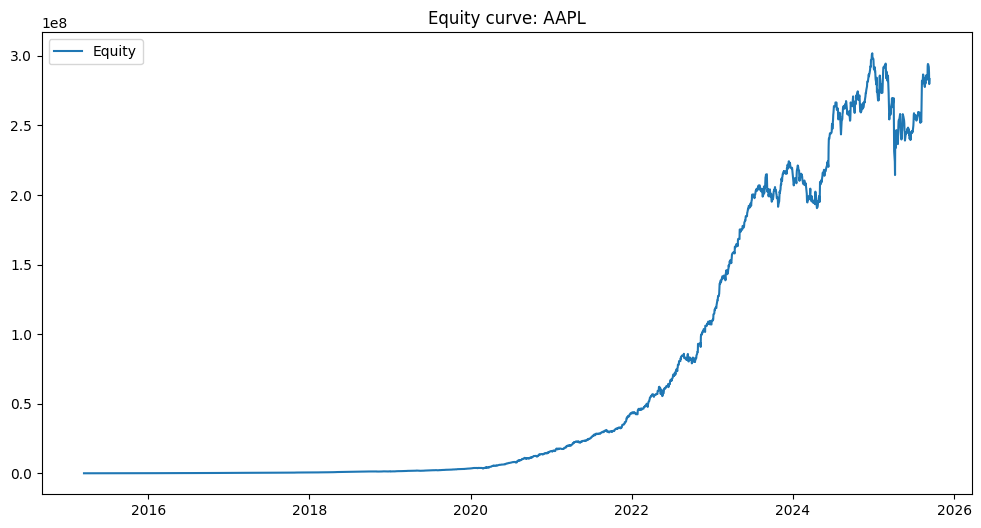

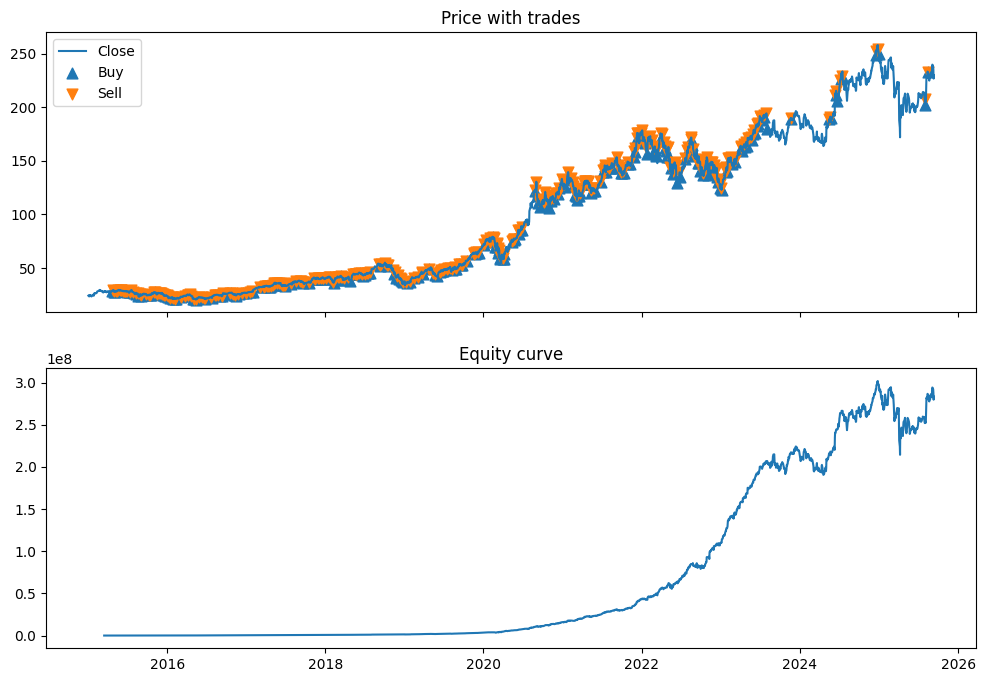

In [85]:
main()